## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import time

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn
from itertools import chain
import cv2
from sklearn.model_selection import train_test_split

## pytorch libs
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping, ModelCheckpoint, LRScheduler

In [2]:
print("torch.cuda.is_available()",torch.cuda.is_available())
print("torch.cuda.current_device()",torch.cuda.current_device())
print("torch.cuda.device(0)",torch.cuda.device(0))
print("torch.cuda.device_count()",torch.cuda.device_count())
print("torch.cuda.get_device_name(0)",torch.cuda.get_device_name(0))
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
if True and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.cuda.is_available() True
torch.cuda.current_device() 0
torch.cuda.device(0) <torch.cuda.device object at 0x000001CD7F679A90>
torch.cuda.device_count() 1
torch.cuda.get_device_name(0) GeForce RTX 3050 Ti Laptop GPU
PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

def load_xray_data():
    """ load data and preprocess required fields"""
    df = pd.read_csv('data/Data_Entry_2017.csv')

    def convert(x):
        """assume that the first number is incorrect for ages above 110"""
        if x > 110:
            x = int(str(x)[1:-1])
        return x

    # convert ages above 110 to lower ages by assuming and non-random consisting error in the data-collection process.
    df['Patient Age'] = df['Patient Age'].apply(lambda x: convert(x))

    disease_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

    for label in disease_labels:
        df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)

    all_image_paths = {os.path.basename(x): x for x in
                       glob(os.path.join('data', 'images*', '*', '*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
    df['path'] = df['Image Index'].map(all_image_paths.get)

    print(df)
    return df, disease_labels

xray_df, disease_labels = load_xray_data()

Scans found: 112120 , Total Headers 112120
             Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gend

In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
# this is already done in the function load_xray_data() is lines:
# disease_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

# for label in disease_labels:
#     df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
# this is already done in the function load_xray_data(), of of the labels corresponds to the 'pneumonia' class.


## Create your training and testing data:

In [6]:
def create_splits(df, test_prop ,class_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    #train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    #train_df, test_df = train_test_split(df, shuffle = True, test_size=0.1, random_state = 0)
    #test_df, valid_df = train_test_split(test_d, shuffle = True, test_size=0.5, random_state = 0)
    
    #split data by patients:
    patient_df=df.groupby(['Patient ID']).first()
    
    train_patient_df, valid_ptient_df = train_test_split(patient_df,stratify = patient_df[class_name],test_size = test_prop)  

    train_patient_df = df[df['Patient ID'].isin(train_patient_df.index.values)]
    valid_ptient_df = df[df['Patient ID'].isin(valid_ptient_df.index.values)]
    
    return train_patient_df, valid_ptient_df


train_data, val_data = create_splits(xray_df, 0.2, 'Pneumonia')

print('train data, n = {}({}% of the data)'.format(len(train_data),round(len(train_data)/len(xray_df)*100,2)))
print('validation, n = {}({}% of the data)'.format(len(val_data),round(len(val_data)/len(xray_df)*100,2)))

print('prop. pneumonia train data: ' + str(round(train_data['Pneumonia'].sum()/len(train_data),4)))
print('prop. pneumonia validation data: ' + str(round(val_data['Pneumonia'].sum()/len(val_data),4)))
    


train data, n = 89557(79.88% of the data)
validation, n = 22563(20.12% of the data)
prop. pneumonia train data: 0.0129
prop. pneumonia validation data: 0.0122


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:

from PIL import Image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.data_frame = df
        self.transforms = transforms
        self.len = df.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        row = self.data_frame.iloc[index]
       
        address = row['path']
        
        x = Image.open(address).convert('RGB')
        
        vec = np.array(row['Pneumonia'], dtype=float)
        y = torch.LongTensor(vec)
        
        if self.transforms:
            x = self.transforms(x)
        return x, y

def my_image_augmentation(vargs):
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data

    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

    # Todo

    transformations = transforms.Compose([#transforms.ToPILImage(),
                                          #transforms.CenterCrop(224),  # 
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation(20),
                                          transforms.ToTensor(),
                                          # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8,
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                          ])
    return transformations


def make_train_gen(trainset, batch_size,transformations):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = ImageDataset(trainset, transformations) 
    trainloader = torch.utils.data.DataLoader(dataset = train_gen, batch_size = batch_size)
    return trainloader


def make_val_gen(valset, batch_size):
    #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data,
    #                                              directory=None,
    #                                              x_col = ,
    #                                              y_col = ',
    #                                              class_mode = 'binary',
    #                                              target_size = ,
    #                                              batch_size = )

    # Todo
    transformations = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    val_gen = ImageDataset(valset, transformations)
    valloader = torch.utils.data.DataLoader(dataset=val_gen, batch_size=batch_size, shuffle=False)

    return valloader

In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data, 64)
#valX, valY = next(iter(val_gen))   

In [9]:
train_gen = make_train_gen(train_data,5,my_image_augmentation(True))
# trainX, trainY = next(iter(train_gen))   

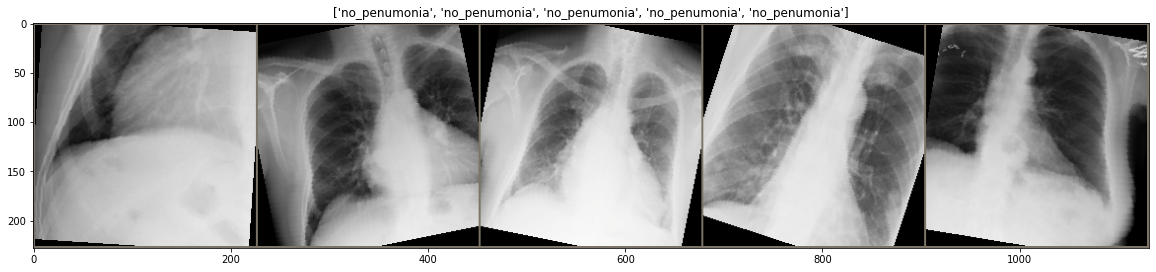

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

# t_x, t_y = next(iter(train_gen))
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         c_ax.set_title('Pneumonia')
#     else:
#         c_ax.set_title('No Pneumonia')
#     c_ax.axis('off')
class_names={0:'no_penumonia',1:'pneumonia'}
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    fix = plt.figure(figsize=(20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_gen))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes.numpy()])

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
class PneumoNet(nn.Module):
    def __init__(self, out_size):
        super(PneumoNet, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)  
        for param in self.vgg16.parameters():
            param.requires_grad = False

        num_features = self.vgg16.classifier[6].in_features
        features = list(self.vgg16.classifier.children())[:-1] # Remove last layer
        # #    The VGG-16 is able to classify 1000 different labels; we just need 2 instead. In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000.
        # #    In PyTorch, we can access the VGG-16 classifier with model.classifier, which is an 6-layer array. We will replace the last entry.
        features.extend([nn.Linear(num_features, out_size)]) # add Linear layer
        self.vgg16.classifier = nn.Sequential(*features)

    def forward(self, x):
        x = self.vgg16(x)
        features= self.vgg16.classifier[6]
        return x, features

# def load_pretrained_model(vargs):
    
#     # model = VGG16(include_top=True, weights='imagenet')
#     # transfer_layer = model.get_layer(lay_of_interest)
#     # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
#     # Todo
#     vgg_model = models.vgg16(pretrained=True)  
#     return vgg_model

In [12]:
# def build_my_model(n_classes):
    
#     # my_model = Sequential()
#     # ....add your pre-trained model, and then whatever additional layers you think you might
#     # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
#     # if you want to compile your model within this function, consider which layers of your pre-trained model, 
#     # you want to freeze before you compile 
    
#     # also make sure you set your optimizer, loss function, and metrics to monitor
    
#     # Todo
    
#     vgg_model = load_pretrained_model(True)
#     for param in vgg_model.parameters():
#         param.requires_grad = False
        
#     num_features = vgg_model.classifier[6].in_features
#     features = list(vgg_model.classifier.children())[:-1] # Remove last layer
#     features.extend([nn.Linear(num_features, n_classes)]) # add Linear layer (same as 'Dense')
#     vgg_model.classifier = nn.Sequential(*features)
        
#     return vgg_model

model =PneumoNet(2).to(device)
print(model)
criterion = nn.CrossEntropyLoss()# this includes a LogSoftmax layer added after the Linear layer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decays the learning rate of each parameter group by gamma every step_size epochs. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = LRScheduler(exp_lr_scheduler)
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

PneumoNet(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

# define training engine (from ignite)
#trainer = create_supervised_trainer(pneumo_model, optimizer, criterion) 

def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch[0].to(device), batch[1].to(device)
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_step)
trainer.add_event_handler(Events.ITERATION_COMPLETED, scheduler)

def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred, _ = model(x)
        return y_pred, y

val_metrics = {
    "accuracy": Accuracy(),
    "nll": Loss(criterion)
}

handler = ModelCheckpoint('.'+os.sep, "{}_my_model.best.hdf5".format('xray_class'), n_saved=3, create_dir=True)

trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), handler, {'mymodel': model})

# for name, metric in val_metrics.items():
#     metric.attach(trainer, name)

## evaluator training evaluator (from ignite)
evaluator = Engine(validation_step)

def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
# Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset).
evaluator.add_event_handler(Events.COMPLETED, handler)



@trainer.on(Events.ITERATION_COMPLETED(every=100))
def log_training_loss(trainer):
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")

### Start training! 

In [ ]:
## train your model
# Todo
# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)
trainer.run(train_gen, max_epochs=25)

Epoch[1] Loss: 0.00
Epoch[1] Loss: 0.00
Epoch[1] Loss: 1.64
Epoch[1] Loss: 0.00
Epoch[1] Loss: 0.00
Epoch[1] Loss: 0.00
Epoch[1] Loss: 0.00
Epoch[1] Loss: 0.00


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)